In [1]:
# setup for google colab

# !pip install spacy==3.1.4
# !python -m spacy download en_core_web_md

# restart runtime before running notebook  

In [2]:
import itertools
from collections import Counter

import spacy
from spacy import displacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dependency parsing with SpaCy

### Load model

In [3]:
nlp = spacy.load("en_core_web_md")

### Load and filter data

In [4]:
df = pd.read_csv('data/dataset.csv')
dataset = df[df['query'] == 'happy+white+woman']
dataset.sample(10)

,title,link,baseline,query,engine
46,Portrait of a happy family. Portrait of a happ...,https://cdn.w600.comps.canstockphoto.com/portr...,46,happy+white+woman,google
18,A happy white woman - a missionary - holding a...,https://c8.alamy.com/comp/KM16K8/a-happy-white...,18,happy+white+woman,google
200,Clipart of a Happy Blond White Woman Measuring...,http://images.clipartof.com/Clipart-Of-A-Happy...,122,happy+white+woman,bing
113,Happy Young Woman Standing Isolated On White B...,http://image.shutterstock.com/z/stock-photo-ha...,35,happy+white+woman,bing
109,Happy Young Woman In White Dress Walking In Sp...,https://thumbs.dreamstime.com/z/happy-young-wo...,31,happy+white+woman,bing
95,Portrait Of The Beautiful Happy Woman In Glass...,http://thumbs.dreamstime.com/z/portrait-beauti...,17,happy+white+woman,bing
65,Retarded High Resolution Stock Photography and...,https://c8.alamy.com/comp/T03ENW/hakendover-fl...,65,happy+white+woman,google
203,Happy Black And White GIF - Find & Share on GIPHY,https://media.giphy.com/media/3ABlAA8hWVBMk/gi...,125,happy+white+woman,bing
32,A White Woman Called the Police on an 8-Year-O...,https://assets.teenvogue.com/photos/5b3001de93...,32,happy+white+woman,google
55,Szélsőközép - Photos | Facebook,https://lookaside.fbsbx.com/lookaside/crawler/...,55,happy+white+woman,google


In [5]:
google_dataset = dataset[dataset['engine']=='google'].copy()
bing_dataset = dataset[dataset['engine']=='bing'].copy()

In [6]:
print("Google dataset size: ", google_dataset.shape[0])
print("Bing dataset size: ", bing_dataset.shape[0])

Google dataset size:  78
Bing dataset size:  134


In [7]:
bing_dataset = bing_dataset[:78]
print("Bing dataset size: ", bing_dataset.shape[0])

Bing dataset size:  78


## Visualize dependencies 
https://spacy.io/usage/visualizers#dep

In [8]:
options={'compact': True, 'distance': 90}

doc = nlp('"Happy White Woman Pregnant, Black Man. Stock Photo - Image of ..."')
displacy.render(doc, style="dep", options=options)

In [9]:
doc = nlp('"Happy Woman With Big Smile, Studio White Background ..."')
displacy.render(doc, style="dep", options=options)

## Get dependency and dependency heads for word 'white'
https://spacy.io/api/dependencyparser  
https://spacy.io/usage/linguistic-features#dependency-parse

In [10]:
# function to get dependency type for word in text 
def get_dep_type(text, word):
    deps = []
    doc = nlp(text)
    for token in doc:
        if token.text.lower() == word.lower():
            deps.append(token.dep_)
    return deps

# function to get dependency head for word in text 
def get_dep_head(text, word):
    heads = []
    doc = nlp(text)
    for token in doc:
        if token.text.lower() == word.lower():
            heads.append(token.head.text.lower())
    return heads

In [11]:
google_dataset['deps'] = google_dataset['title'].apply(get_dep_type, word='white')
google_dataset['deps head'] = google_dataset['title'].apply(get_dep_head, word='white')

bing_dataset['deps'] = bing_dataset['title'].apply(get_dep_type, word='white')
bing_dataset['deps head'] = bing_dataset['title'].apply(get_dep_head, word='white')

In [12]:
# Check dependency types for word white in titles
deps = list(itertools.chain.from_iterable(google_dataset['deps']))
Counter(deps)

Counter({'amod': 37, 'compound': 33})

In [13]:
deps = list(itertools.chain.from_iterable(bing_dataset['deps']))
Counter(deps)

Counter({'compound': 40, 'amod': 8, 'conj': 1, 'pobj': 4})

In [14]:
# Count dependency heads for word white in titles 
bing_heads = list(itertools.chain.from_iterable(bing_dataset['deps head']))
bing_cnt = Counter(bing_heads)
bing_cnt.most_common()

[('background', 13),
 ('stock', 8),
 ('happy', 4),
 ('|', 3),
 ('shirt', 2),
 ('woman', 2),
 ('sweater', 2),
 ('over', 2),
 ('photo', 2),
 ('free', 1),
 ('hood', 1),
 ('black', 1),
 ('underwear', 1),
 ('dress', 1),
 ('looking', 1),
 ('american', 1),
 ('royalty', 1),
 ('sarong', 1),
 ('on', 1),
 ('teeth', 1),
 ('portrait', 1),
 ('surface', 1),
 ('with', 1),
 ('wall', 1)]

In [15]:
google_heads = list(itertools.chain.from_iterable(google_dataset['deps head']))
google_cnt = Counter(google_heads)
google_cnt.most_common()

[('woman', 48),
 ('women', 10),
 ('stock', 3),
 ('background', 2),
 ('man', 1),
 ('underwear', 1),
 ('men', 1),
 ('shirts', 1),
 ('supremacy', 1),
 ('collar', 1),
 ('teeth', 1)]

### Plot results
We will use bar plot to show most common heads.

In [16]:
cnt = google_cnt + bing_cnt
labels = [k for k, v in cnt.most_common(15)]
google_values = [google_cnt[lbl] for lbl in labels]
bing_values = [bing_cnt[lbl] for lbl in labels]

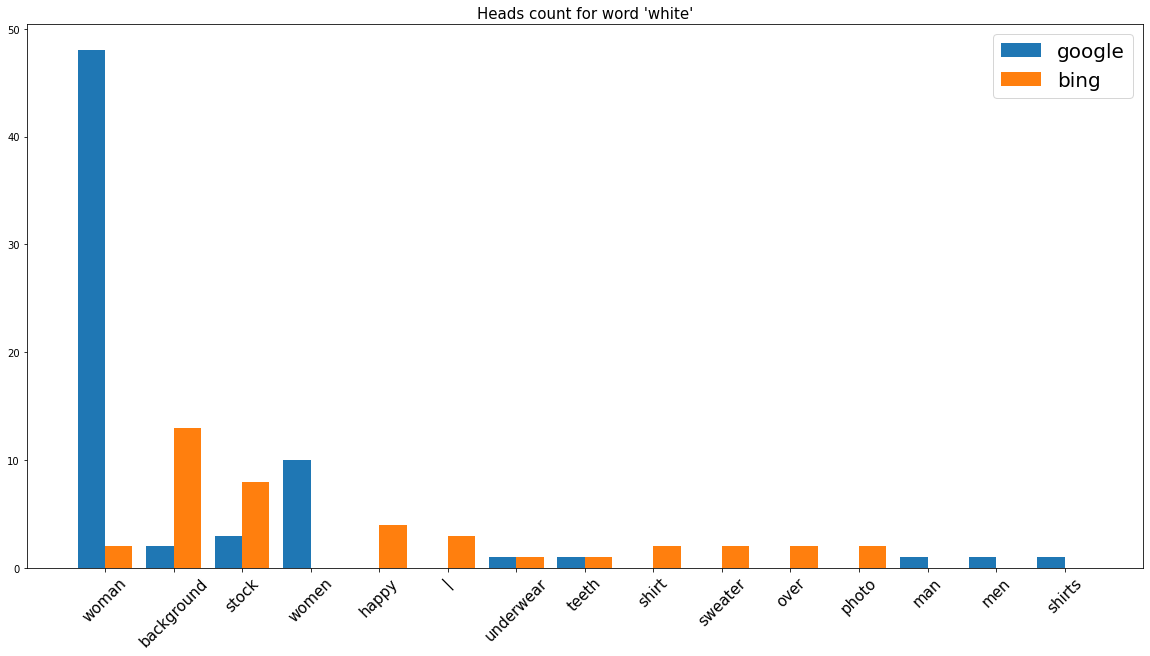

In [22]:
plt.rcParams["figure.figsize"] = (20,10)

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
ax.bar(x-width/2, google_values, width=width, label='google')
ax.bar(x+width/2, bing_values, width=width, label='bing')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=15, rotation=45)
ax.legend(fontsize=20)
ax.set_title("Heads count for word 'white'", fontsize=15)

plt.show()

## Check other queries

In [18]:
a_dataset = df[df['query'] == 'happy+asian+woman'].copy()
b_dataset = df[df['query'] == 'happy+black+woman'].copy()

a_dataset['deps head'] = a_dataset['title'].apply(get_dep_head, word='asian')
b_dataset['deps head'] = b_dataset['title'].apply(get_dep_head, word='black')

a_heads = list(itertools.chain.from_iterable(a_dataset['deps head']))
b_heads = list(itertools.chain.from_iterable(b_dataset['deps head']))

In [19]:
a_cnt = Counter(a_heads)
a_cnt.most_common()

[('woman', 122),
 ('girl', 5),
 ('women', 4),
 ('teenage', 4),
 ('image', 3),
 ('business', 3),
 ('images', 3),
 ('photo', 3),
 ('young', 2),
 ('girls', 2),
 ('girlfriends', 1),
 ('asian', 1),
 ('people', 1),
 ('wife', 1),
 ('couple', 1)]

In [20]:
b_cnt = Counter(b_heads)
b_cnt.most_common()

[('woman', 114),
 ('women', 16),
 ('girl', 4),
 ('lady', 3),
 ('images', 2),
 ('business', 2),
 ('thurman', 1),
 ('|', 1),
 ('stock', 1),
 ('mug', 1),
 ('people', 1),
 ('grandma', 1),
 ('african', 1),
 ('version', 1),
 ('female', 1),
 ('is', 1),
 ('black', 1)]

## TODO:
* Check what noun phrases we can find in documents. Use doc.noun_chunks iterator.  
https://spacy.io/api/doc#noun_chunks